## Import Libraries & Data

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import plotly.express as px
import html
import re
import string
import spacy
import math

import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import nltk
from nltk import word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')

from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from yellowbrick.model_selection import learning_curve
import os

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from warnings import filterwarnings
filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /Users/mac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# import data
df = pd.read_pickle("../data/training_data.pkl")
df.head()

,hashtags,favorite_count,id,lang,place,retweet_count,text,user_location,tweet_proc_length,target
0,"[hack4climate, blockchain, climateaction, clim...",4,928605716159574016,en,NaN,1,day hackclimate look forward exciting event bl...,"Zürich, Schweiz",17,1
1,"[climatechange, climateaction]",1,954288658361802752,en,NaN,1,good way predict future create abraham lincoln...,"Tampere, Finland",15,1
2,"[protectwhatyoulove, climatechangeisreal, anim...",0,1012691887440814086,en,NaN,0,accept world way power stand change want prote...,NaN,31,1
3,"[climatechange, climateaction]",0,942162022145380352,en,NaN,0,landfill significant source methane emission c...,Globally l Planet Earth,9,1
4,"[climatechange, climateaction]",0,954283347399847936,en,NaN,1,sea level expect rise metre melt ice wwf clima...,Online l Globally l Earth,16,1


In [3]:
# keep only text and target columns

col_list = ['text','target']
df = df.loc[:, col_list]
df

,text,target
0,day hackclimate look forward exciting event bl...,1
1,good way predict future create abraham lincoln...,1
2,accept world way power stand change want prote...,1
3,landfill significant source methane emission c...,1
4,sea level expect rise metre melt ice wwf clima...,1
...,...,...
276407,waronerror episode promote illusive fear sell ...,0
276408,new study find cosmic ray solar activity great...,0
276409,global warming expert think melt ice cause sea...,0
276410,blizzard noreaster oh day al gore democrats gl...,0


In [4]:
# check class distribution

df['target'].value_counts()

1    201950
0     74462
Name: target, dtype: int64

In [5]:
# split to training and test data

X = df['text']
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=100)

In [6]:
# make stopwords list (regular english + definitive hashtags)

definitive_hashtags = ['climatechangeisreal', 'actonclimate', 'extinctionrebellion', 'climateemergency', 
                 'climateactionnow', 'capitalism', 'public_health', 'climateaction', 'humanityextinction',
                 'activism', 'noplanetb', 'savetheplanet', 'climateaction','climatechangeisfalse', 
                 'climatechangenotreal', 'climatechangehoax','globalwarminghoax', 'tcot', 'ccot', 'tlot', 
                 'pjnet', 'rednationrising', 'votered','libtard', 'libtards', 'maga', 'climatedeniers', 
                 'climatehoax', 'globalcooling','climatechangescam', 'climatehysteria', 'globalwarmingisahoax', 
                 'globalwarmingscam', 'globalcooling']

stop_words = set(stopwords.words("english"))
stopwords_all = stop_words.union(definitive_hashtags)

## Baseline Model (Accuracy: 73%, F1: 42%)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state = 42)

dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train,y_train)
y_pred = dummy.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     14928
           1       0.73      1.00      0.84     40355

    accuracy                           0.73     55283
   macro avg       0.36      0.50      0.42     55283
weighted avg       0.53      0.73      0.62     55283



In [8]:
# confusion matrix: 40,355 true believers, 14,928 predicted believers

print(confusion_matrix(y_test, y_pred, labels = [1,0]))

[[40355     0]
 [14928     0]]


In [9]:
# save baseline model

filename = 'baseline_task1.pkl'
pickle.dump(dummy, open(filename, 'wb'))

# Creating Undersampled and Oversampled Datasets
This is to address class imbalance

In [10]:
# Separating X and y to prepare for resampling

X = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [11]:
# Random Undersampling

print("Before undersampling: ", Counter(y))

# define undersampling strategy & fit to data
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_resample(X, y)
X_rus = X_rus['text']

print("After undersampling: ", Counter(y_rus))

Before undersampling:  Counter({1: 201950, 0: 74462})
After undersampling:  Counter({0: 74462, 1: 74462})


In [12]:
# Random Oversampling

# summarize class distribution
print("Before oversampling: ", Counter(y))

# define undersampling strategy & fit to data
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X, y)
X_ros = X_ros['text']

print("After oversampling: ", Counter(y_ros))

Before oversampling:  Counter({1: 201950, 0: 74462})
After oversampling:  Counter({1: 201950, 0: 201950})


# Naive Bayes Classifier

## NB + TF-IDF

In [77]:
# TF-IDF ngram range = 2,3 + Random Undersampling (Accuracy/F1 Score 81%)

X_train, X_test, y_train, y_test = train_test_split(X_rus,y_rus,test_size=0.2, random_state = 42)

vect = TfidfVectorizer(ngram_range=(2,3), max_df = 0.8, min_df = 3, stop_words=stopwords_all)

model = MultinomialNB()

X_train_vec = vect.fit_transform(X_train)
X_test_vec  = vect.transform(X_test)

model.fit(X_train_vec, y_train);
y_pred = model.predict(X_test_vec)

print("NB + TF-IDF (n-gram range = 2,3) + Random UnderSampling")
print(classification_report(y_test, y_pred))

LR + TF-IDF (n-gram range = 2,3) + Random UnderSampling
              precision    recall  f1-score   support

           0       0.79      0.85      0.82     14769
           1       0.84      0.78      0.81     15016

    accuracy                           0.81     29785
   macro avg       0.81      0.81      0.81     29785
weighted avg       0.81      0.81      0.81     29785



In [78]:
# TF-IDF ngram range = 1,3 + Random Undersampling (Accuracy/F1 Score 88%)

X_train, X_test, y_train, y_test = train_test_split(X_rus,y_rus,test_size=0.2, random_state = 42)

vect = TfidfVectorizer(ngram_range=(1,3), max_df = 0.8, min_df = 3, stop_words=stopwords_all)

model = MultinomialNB()

X_train_vec = vect.fit_transform(X_train)
X_test_vec  = vect.transform(X_test)

model.fit(X_train_vec, y_train);
y_pred = model.predict(X_test_vec)

print("NB + TF-IDF (n-gram range = 1,3) + Random UnderSampling")
print(classification_report(y_test, y_pred))

LR + TF-IDF (n-gram range = 1,3) + Random UnderSampling
              precision    recall  f1-score   support

           0       0.87      0.89      0.88     14769
           1       0.89      0.87      0.88     15016

    accuracy                           0.88     29785
   macro avg       0.88      0.88      0.88     29785
weighted avg       0.88      0.88      0.88     29785



In [79]:
# TF-IDF ngram range = 2,3 + Random OverSampling (Accuracy/F1 Score 87%)

X_train, X_test, y_train, y_test = train_test_split(X_ros,y_ros,test_size=0.2, random_state = 42)

vect = TfidfVectorizer(ngram_range=(2,3), max_df = 0.8, min_df = 3, stop_words=stopwords_all)

model = MultinomialNB()

X_train_vec = vect.fit_transform(X_train)
X_test_vec  = vect.transform(X_test)

model.fit(X_train_vec, y_train);
y_pred = model.predict(X_test_vec)

print("NB + TF-IDF (n-gram range = 2,3) + Random OverSampling")
print(classification_report(y_test, y_pred))

LR + TF-IDF (n-gram range = 2,3) + Random OverSampling
              precision    recall  f1-score   support

           0       0.88      0.86      0.87     40263
           1       0.86      0.89      0.88     40517

    accuracy                           0.87     80780
   macro avg       0.87      0.87      0.87     80780
weighted avg       0.87      0.87      0.87     80780



In [80]:
# TF-IDF ngram range = 1,3 + Random OverSampling (Accuracy/F1 Score 90%)

X_train, X_test, y_train, y_test = train_test_split(X_ros,y_ros,test_size=0.2, random_state = 42)

vect = TfidfVectorizer(ngram_range=(1,3), max_df = 0.8, min_df = 3, stop_words=stopwords_all)

model = MultinomialNB()

X_train_vec = vect.fit_transform(X_train)
X_test_vec  = vect.transform(X_test)

model.fit(X_train_vec, y_train);
y_pred = model.predict(X_test_vec)

print("NB + TF-IDF (n-gram range = 1,3) + Random OverSampling")
print(classification_report(y_test, y_pred))

LR + TF-IDF (n-gram range = 1,3) + Random OverSampling
              precision    recall  f1-score   support

           0       0.95      0.85      0.90     40263
           1       0.87      0.96      0.91     40517

    accuracy                           0.90     80780
   macro avg       0.91      0.90      0.90     80780
weighted avg       0.91      0.90      0.90     80780



## NB + CountVectorizer

In [82]:
# Count Vectorizer ngram range = 2,3 + Random OverSampling (Accuracy/F1 Score 86%)

X_train, X_test, y_train, y_test = train_test_split(X_ros,y_ros,test_size=0.2, random_state = 42)

vect = CountVectorizer(ngram_range=(2,3),max_df = 0.8, min_df = 3, stop_words=stopwords_all)

model = MultinomialNB()

X_train_vec = vect.fit_transform(X_train)
X_test_vec  = vect.transform(X_test)

model.fit(X_train_vec, y_train);
y_pred = model.predict(X_test_vec)

print("NB + CountVectorizer (n-gram range = 2,3) + Random OverSampling")
print(classification_report(y_test, y_pred))

NB + CountVectorizer (n-gram range = 2,3) + Random OverSampling
              precision    recall  f1-score   support

           0       0.88      0.83      0.85     40263
           1       0.84      0.89      0.86     40517

    accuracy                           0.86     80780
   macro avg       0.86      0.86      0.86     80780
weighted avg       0.86      0.86      0.86     80780



In [83]:
# Count Vectorizer ngram range = 1,3 + Random UnderSampling (Accuracy/F1 Score 88%)

X_train, X_test, y_train, y_test = train_test_split(X_rus,y_rus,test_size=0.2, random_state = 42)

vect = CountVectorizer(ngram_range=(1,3),max_df = 0.8, min_df = 3, stop_words=stopwords_all)

model = MultinomialNB()

X_train_vec = vect.fit_transform(X_train)
X_test_vec  = vect.transform(X_test)

model.fit(X_train_vec, y_train);
y_pred = model.predict(X_test_vec)

print("NB + CountVectorizer (n-gram range = 1,3) + Random UnderSampling")
print(classification_report(y_test, y_pred))

NB + CountVectorizer (n-gram range = 1,3) + Random UnderSampling
              precision    recall  f1-score   support

           0       0.87      0.88      0.88     14769
           1       0.88      0.88      0.88     15016

    accuracy                           0.88     29785
   macro avg       0.88      0.88      0.88     29785
weighted avg       0.88      0.88      0.88     29785



In [84]:
# Count Vectorizer ngram range = 2,3 + Random UnderSampling (Accuracy/F1 Score 81%)

X_train, X_test, y_train, y_test = train_test_split(X_rus,y_rus,test_size=0.2, random_state = 42)

vect = CountVectorizer(ngram_range=(2,3),max_df = 0.8, min_df = 3, stop_words=stopwords_all)

model = MultinomialNB()

X_train_vec = vect.fit_transform(X_train)
X_test_vec  = vect.transform(X_test)

model.fit(X_train_vec, y_train);
y_pred = model.predict(X_test_vec)

print("NB + CountVectorizer (n-gram range = 2,3) + Random UnderSampling")
print(classification_report(y_test, y_pred))

NB + CountVectorizer (n-gram range = 2,3) + Random UnderSampling
              precision    recall  f1-score   support

           0       0.79      0.84      0.81     14769
           1       0.83      0.78      0.81     15016

    accuracy                           0.81     29785
   macro avg       0.81      0.81      0.81     29785
weighted avg       0.81      0.81      0.81     29785



In [85]:
# Count Vectorizer ngram range = 1,3 + Random OverSampling (Accuracy/F1 Score 90%)

X_train, X_test, y_train, y_test = train_test_split(X_ros,y_ros,test_size=0.2, random_state = 42)

vect = CountVectorizer(ngram_range=(1,3),max_df = 0.8, min_df = 3, stop_words=stopwords_all)

model = MultinomialNB()

X_train_vec = vect.fit_transform(X_train)
X_test_vec  = vect.transform(X_test)

model.fit(X_train_vec, y_train);
y_pred = model.predict(X_test_vec)

print("NB + CountVectorizer (n-gram range = 1,3) + Random OverSampling")
print(classification_report(y_test, y_pred))

NB + CountVectorizer (n-gram range = 1,3) + Random OverSampling
              precision    recall  f1-score   support

           0       0.95      0.86      0.90     40263
           1       0.87      0.95      0.91     40517

    accuracy                           0.90     80780
   macro avg       0.91      0.90      0.90     80780
weighted avg       0.91      0.90      0.90     80780



In [89]:
model = MultinomialNB()
model.get_params().keys()

dict_keys(['alpha', 'class_prior', 'fit_prior'])

In [90]:
#Grid Search for best parameters

X_train, X_test, y_train, y_test = train_test_split(X_ros,y_ros,test_size=0.2, random_state = 42)

# vectorize with the chosen best vectorizer
vect = CountVectorizer(ngram_range=(1,3),max_df = 0.8, min_df = 3, stop_words=stopwords_all)

X_train_vec = vect.fit_transform(X_train)
X_test_vec  = vect.transform(X_test)

params = {'alpha': [0,1],
          'fit_prior': [True, False]}

grid = GridSearchCV(MultinomialNB(), params, cv=3, scoring='f1')
grid.fit(X_train_vec, y_train)
y_true, y_pred = y_test, grid.predict(X_test_vec)

print('Best Parameters are:', grid.best_params_)
print(classification_report(y_true, y_pred))

Best Parameters are: {'alpha': 0, 'fit_prior': False}
              precision    recall  f1-score   support

           0       0.93      0.91      0.92     40263
           1       0.91      0.93      0.92     40517

    accuracy                           0.92     80780
   macro avg       0.92      0.92      0.92     80780
weighted avg       0.92      0.92      0.92     80780



In [93]:
# fitting model with best parameters (Accuracy/F1 Score 92%)

X_train, X_test, y_train, y_test = train_test_split(X_ros,y_ros,test_size=0.2, random_state = 42)

vect = CountVectorizer(ngram_range=(1,3),max_df = 0.8, min_df = 3, stop_words=stopwords_all)

model = MultinomialNB(alpha=0,fit_prior=False)

X_train_vec = vect.fit_transform(X_train)
X_test_vec  = vect.transform(X_test)

model.fit(X_train_vec, y_train);
y_pred = model.predict(X_test_vec)

print("NB + CountVectorizer (n-gram range = 1,3) + Random OverSampling")
print(classification_report(y_test, y_pred))

NB + CountVectorizer (n-gram range = 1,3) + Random OverSampling
              precision    recall  f1-score   support

           0       0.93      0.91      0.92     40263
           1       0.91      0.93      0.92     40517

    accuracy                           0.92     80780
   macro avg       0.92      0.92      0.92     80780
weighted avg       0.92      0.92      0.92     80780



# Logistic Regression Classifier

## LR + TF-IDF

In [13]:
# TF-IDF ngram range = 2,3 + Random Undersampling (Accuracy/F1 Score 80%)

X_train, X_test, y_train, y_test = train_test_split(X_rus,y_rus,test_size=0.2, random_state = 42)

vect = TfidfVectorizer(ngram_range=(2,3), max_df = 0.8, min_df = 3, stop_words=stopwords_all)

model = LogisticRegression(max_iter=1000)

X_train_vec = vect.fit_transform(X_train)
X_test_vec  = vect.transform(X_test)

model.fit(X_train_vec, y_train);
y_pred = model.predict(X_test_vec)

print("LR + TF-IDF (n-gram range = 2,3) + Random UnderSampling")
print(classification_report(y_test, y_pred))

LR + TF-IDF (n-gram range = 2,3) + Random UnderSampling
              precision    recall  f1-score   support

           0       0.78      0.85      0.81     14769
           1       0.84      0.76      0.80     15016

    accuracy                           0.80     29785
   macro avg       0.81      0.81      0.80     29785
weighted avg       0.81      0.80      0.80     29785



In [14]:
# TF-IDF ngram range = 2,3 + Random OverSampling (Accuracy/F1 Score 88%)

X_train, X_test, y_train, y_test = train_test_split(X_ros,y_ros,test_size=0.2, random_state = 42)

vect = TfidfVectorizer(ngram_range=(2,3), max_df = 0.8, min_df = 3, stop_words=stopwords_all)

model = LogisticRegression(max_iter=1000)

X_train_vec = vect.fit_transform(X_train)
X_test_vec  = vect.transform(X_test)

model.fit(X_train_vec, y_train);
y_pred = model.predict(X_test_vec)

print("LR + TF-IDF (n-gram range = 2,3) + Random OverSampling")
print(classification_report(y_test, y_pred))

LR + TF-IDF (n-gram range = 2,3) + Random OverSampling
              precision    recall  f1-score   support

           0       0.85      0.92      0.89     40263
           1       0.91      0.84      0.88     40517

    accuracy                           0.88     80780
   macro avg       0.88      0.88      0.88     80780
weighted avg       0.88      0.88      0.88     80780



In [15]:
# TF-IDF n-gram range = 1,3 + Random UnderSampling (Accuracy/F1 Score 88%)

X_train, X_test, y_train, y_test = train_test_split(X_rus,y_rus,test_size=0.2, random_state = 42)

vect = TfidfVectorizer(ngram_range=(1,3), max_df = 0.8, min_df = 3, stop_words=stopwords_all)

model = LogisticRegression(max_iter=1000)

X_train_vec = vect.fit_transform(X_train)
X_test_vec  = vect.transform(X_test)

model.fit(X_train_vec, y_train)
y_pred = model.predict(X_test_vec)

print("LR + TF-IDF (n-gram range = 1,3) + Random UnderSampling")
print(classification_report(y_test, y_pred))

LR + TF-IDF (n-gram range = 1,3) + Random UnderSampling
              precision    recall  f1-score   support

           0       0.89      0.88      0.88     14769
           1       0.88      0.89      0.88     15016

    accuracy                           0.88     29785
   macro avg       0.88      0.88      0.88     29785
weighted avg       0.88      0.88      0.88     29785



In [16]:
# TF-IDF ngram range = 1,3 + Random OverSampling (Accuracy/F1 Score 92%)

X_train, X_test, y_train, y_test = train_test_split(X_ros,y_ros,test_size=0.2, random_state = 42)

vect = TfidfVectorizer(ngram_range=(1,3), max_df = 0.8, min_df = 3, stop_words=stopwords_all)

model = LogisticRegression(max_iter=1000)

X_train_vec = vect.fit_transform(X_train)
X_test_vec  = vect.transform(X_test)

model.fit(X_train_vec, y_train);
y_pred = model.predict(X_test_vec)

print("LR + TF-IDF (n-gram range = 1,3) + Random OverSampling")
print(classification_report(y_test, y_pred))

LR + TF-IDF (n-gram range = 1,3) + Random OverSampling
              precision    recall  f1-score   support

           0       0.92      0.92      0.92     40263
           1       0.92      0.92      0.92     40517

    accuracy                           0.92     80780
   macro avg       0.92      0.92      0.92     80780
weighted avg       0.92      0.92      0.92     80780



## Logistic Regression + CountVectorizer

In [17]:
# Count Vectorizer ngram range = 2,3 + Random UnderSampling (Accuracy/F1 Score 80%)

X_train, X_test, y_train, y_test = train_test_split(X_rus,y_rus,test_size=0.2, random_state = 42)

vect = CountVectorizer(ngram_range=(2,3),max_df = 0.8, min_df = 3, stop_words=stopwords_all)

model = LogisticRegression(max_iter=1000)

X_train_vec = vect.fit_transform(X_train)
X_test_vec  = vect.transform(X_test)

model.fit(X_train_vec, y_train);
y_pred = model.predict(X_test_vec)

print("LR + CountVectorizer (n-gram range = 2,3) + Random UnderSampling")
print(classification_report(y_test, y_pred))

LR + CountVectorizer (n-gram range = 2,3) + Random UnderSampling
              precision    recall  f1-score   support

           0       0.77      0.85      0.81     14769
           1       0.84      0.75      0.79     15016

    accuracy                           0.80     29785
   macro avg       0.80      0.80      0.80     29785
weighted avg       0.80      0.80      0.80     29785



In [18]:
# Count Vectorizer ngram range = 2,3 + Random OverSampling (Accuracy/F1 Score 91%)

X_train, X_test, y_train, y_test = train_test_split(X_ros,y_ros,test_size=0.2, random_state = 42)

vect = CountVectorizer(ngram_range=(2,3),max_df = 0.8, min_df = 3, stop_words=stopwords_all)

model = LogisticRegression(max_iter=1000)

X_train_vec = vect.fit_transform(X_train)
X_test_vec  = vect.transform(X_test)

model.fit(X_train_vec, y_train);
y_pred = model.predict(X_test_vec)

print("LR + CountVectorizer (n-gram range = 2,3) + Random OverSampling")
print(classification_report(y_test, y_pred))

LR + CountVectorizer (n-gram range = 2,3) + Random OverSampling
              precision    recall  f1-score   support

           0       0.94      0.87      0.90     40263
           1       0.88      0.94      0.91     40517

    accuracy                           0.91     80780
   macro avg       0.91      0.91      0.91     80780
weighted avg       0.91      0.91      0.91     80780



In [19]:
# Count Vectorizer ngram range = 1,3 + Random UnderSampling (Accuracy/F1 Score 88%)

X_train, X_test, y_train, y_test = train_test_split(X_rus,y_rus,test_size=0.2, random_state = 42)

vect = CountVectorizer(ngram_range=(1,3),max_df = 0.8, min_df = 3, stop_words=stopwords_all)

model = LogisticRegression(max_iter=1000)

X_train_vec = vect.fit_transform(X_train)
X_test_vec  = vect.transform(X_test)

model.fit(X_train_vec, y_train);
y_pred = model.predict(X_test_vec)

print("LR + CountVectorizer (n-gram range = 1,3) + Random UnderSampling")
print(classification_report(y_test, y_pred))

LR + CountVectorizer (n-gram range = 1,3) + Random UnderSampling
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     14769
           1       0.88      0.88      0.88     15016

    accuracy                           0.88     29785
   macro avg       0.88      0.88      0.88     29785
weighted avg       0.88      0.88      0.88     29785



In [20]:
# Count Vectorizer ngram range = 1,3 (Accuracy/F1 Score 94%, BEST)

X_train, X_test, y_train, y_test = train_test_split(X_ros,y_ros,test_size=0.2, random_state = 42)

vect = CountVectorizer(ngram_range=(1,3),max_df = 0.8, min_df = 3, stop_words=stopwords_all)

model = LogisticRegression(max_iter=1000)

X_train_vec = vect.fit_transform(X_train)
X_test_vec  = vect.transform(X_test)

model.fit(X_train_vec, y_train);
y_pred = model.predict(X_test_vec)

print("LR + CountVectorizer (n-gram range = 1,3) + Random OverSampling")
print(classification_report(y_test, y_pred))

LR + CountVectorizer (n-gram range = 1,3) + Random OverSampling
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     40263
           1       0.95      0.94      0.95     40517

    accuracy                           0.95     80780
   macro avg       0.95      0.95      0.95     80780
weighted avg       0.95      0.95      0.95     80780



In [21]:
confusion_matrix(y_test,y_pred,labels=[1,0])

array([[38288,  2229],
       [ 1933, 38330]])

In [22]:
filename = 'LR_95%'
pickle.dump(model, open(filename, 'wb'))

# Model Results

**Baseline Dummy Model:**
- Accuracy: 73%, F1: 42%

**Naive Bayes Results:**
- TF-IDF ngram range = 2,3 + Random Undersampling (Accuracy/F1 Score 81%)
- TF-IDF ngram range = 1,3 + Random Undersampling (Accuracy/F1 Score 88%)
- TF-IDF ngram range = 2,3 + Random OverSampling (Accuracy/F1 Score 87%)
- TF-IDF ngram range = 1,3 + Random OverSampling (Accuracy/F1 Score 90%)
- Count Vectorizer ngram range = 1,3 + Random OverSampling (Accuracy/F1 Score 90%)
- Count Vectorizer ngram range = 2,3 + Random OverSampling (Accuracy/F1 Score 86%)
- Count Vectorizer ngram range = 1,3 + Random UnderSampling (Accuracy/F1 Score 88%)
- Count Vectorizer ngram range = 2,3 + Random UnderSampling (Accuracy/F1 Score 81%)

**Logistic Regression Results**
- TF-IDF ngram range = 2,3 + Random UnderSampling (Accuracy/F1 Score 80%)
- TF-IDF ngram range = 2,3 + Random OverSampling (Accuracy/F1 Score 88%)
- TF-IDF ngram range = 1,3 + Random UnderSampling (Accuracy/F1 Score 88%)
- TF-IDF ngram range = 1,3 + Random OverSampling (Accuracy/F1 Score 92%)
- Count Vectorizer ngram range = 2,3 + Random UnderSampling (Accuracy/F1 Score 80%)
- Count Vectorizer ngram range = 2,3 + Random OverSampling (Accuracy/F1 Score 91%)
- Count Vectorizer ngram range = 1,3 + Random UnderSampling (Accuracy/F1 Score 88%)
- Count Vectorizer ngram range = 1,3 (Accuracy/F1 Score 95%)

**BEST PERFORMING MODEL: LR Count Vectorizer ngram range = 1,3 (Accuracy/F1 Score 95%)**

## Logistic Regression Grid Search

In [23]:
# GridSearch for best parameters

# train/test split with oversampled dataset
X_train, X_test, y_train, y_test = train_test_split(X_ros,y_ros,test_size=0.2, random_state = 42)

# vectorize with the chosen best vectorizer
vect = CountVectorizer(ngram_range=(1,3),max_df = 0.8, min_df = 3, stop_words=stopwords_all)

X_train_vec = vect.fit_transform(X_train)
X_test_vec  = vect.transform(X_test)

params = {'penalty': ['none', 'l2'], 'solver': ['liblinear'], 'C': [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]}

grid = GridSearchCV(LogisticRegression(), params, cv=3, scoring='f1')
grid.fit(X_train_vec, y_train)
y_true, y_pred = y_test, grid.predict(X_test_vec)

print('Best Parameters are:', grid.best_params_)
print(classification_report(y_true, y_pred))

Best Parameters are: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     40263
           1       0.97      0.94      0.96     40517

    accuracy                           0.96     80780
   macro avg       0.96      0.96      0.96     80780
weighted avg       0.96      0.96      0.96     80780



In [56]:
# train model with optimal parameters

X_train, X_test, y_train, y_test = train_test_split(X_ros,y_ros,test_size=0.2, random_state = 42)

vect = CountVectorizer(ngram_range=(1,3),max_df = 0.8, min_df = 3, stop_words=stopwords_all)

model = LogisticRegression(max_iter=1000, solver='liblinear', penalty='l2', C=10)

X_train_vec = vect.fit_transform(X_train)
X_test_vec  = vect.transform(X_test)

model.fit(X_train_vec, y_train)
y_pred = model.predict(X_test_vec)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96     40263
           1       0.97      0.94      0.96     40517

    accuracy                           0.96     80780
   macro avg       0.96      0.96      0.96     80780
weighted avg       0.96      0.96      0.96     80780



In [27]:
# get ROC AUC scores

from sklearn.metrics import roc_auc_score, roc_curve

train_probs = model.predict_proba(X_train_vec)[:,1] 
probs = model.predict_proba(X_test_vec)[:, 1]
train_predictions = model.predict(X_train_vec)

print(f'Train ROC AUC Score: {round(roc_auc_score(y_train, train_probs),2)}')
print(f'Test ROC AUC  Score: {round(roc_auc_score(y_test, probs),2)}')

Train ROC AUC Score: 1.0
Test ROC AUC  Score: 0.99


Baseline: {1.0} Test: {0.94} Train: {0.99}
Baseline: {0.5} Test: {0.97} Train: {1.0}
Baseline: {0.5} Test: {0.99} Train: {1.0}


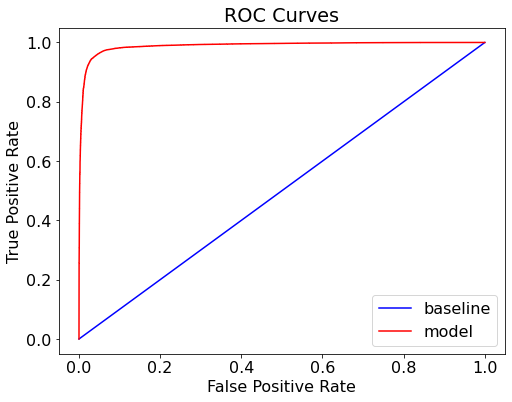

In [29]:
#https://towardsdatascience.com/my-random-forest-classifier-cheat-sheet-in-python-fedb84f8cf4f

def evaluate_model(y_pred, probs,train_predictions, train_probs):
    baseline = {}
    baseline['recall']=recall_score(y_test,
                    [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test,
                    [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5
    results = {}
    results['recall'] = recall_score(y_test, y_pred)
    results['precision'] = precision_score(y_test, y_pred)
    results['roc'] = roc_auc_score(y_test, probs)
    train_results = {}
    train_results['recall'] = recall_score(y_train, train_predictions)
    train_results['precision'] = precision_score(y_train, train_predictions)
    train_results['roc'] = roc_auc_score(y_train, train_probs)
    for metric in ['recall', 'precision', 'roc']:  
          print('Baseline:', {round(baseline[metric], 2)}, 
                 'Test:', {round(results[metric], 2)}, 
                 'Train:', {round(train_results[metric], 2)})
     # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    model_fpr, model_tpr, _ = roc_curve(y_test, probs)
    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate');
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    plt.show();

evaluate_model(y_pred,probs,train_predictions,train_probs)

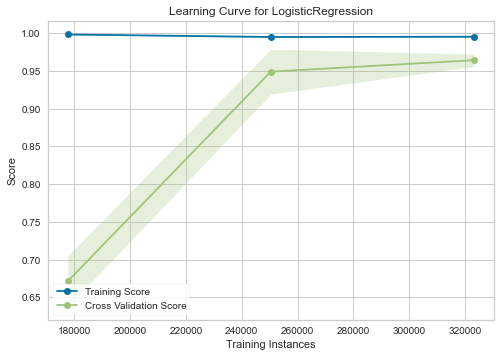

LearningCurve(ax=<AxesSubplot:title={'center':'Learning Curve for LogisticRegression'}, xlabel='Training Instances', ylabel='Score'>,
              cv=5,
              estimator=LogisticRegression(C=10, max_iter=1000,
                                           solver='liblinear'),
              scoring='accuracy')


In [38]:
# Checking learning curve

X_train = vect.fit_transform(X_ros)
print(learning_curve(model, X_train, y_ros, cv=5, scoring='accuracy'))

## Finding the Optimal Threshold
https://towardsdatascience.com/optimal-threshold-for-imbalanced-classification-5884e870c293

In [40]:
# Predict the probabilities
y_pred = model.predict_proba(X_test_vec)

# Get the probabilities for positive class
y_pred = y_pred[:, 1]

In [41]:
# Create the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [42]:
# Plot the ROC curve
df_fpr_tpr = pd.DataFrame({'FPR':fpr, 'TPR':tpr, 'Threshold':thresholds})
df_fpr_tpr.head()

,FPR,TPR,Threshold
0,0.0,0.000000,2.0
1,0.0,0.000469,1.0
2,0.0,0.000642,1.0
3,0.0,0.000716,1.0
4,0.0,0.000814,1.0


In [46]:
from plotnine import *
import plotnine

In [49]:
# Calculate the G-mean
gmean = np.sqrt(tpr * (1 - fpr))

# Find the optimal threshold
index = np.argmax(gmean)
thresholdOpt = round(thresholds[index], ndigits = 4)
gmeanOpt = round(gmean[index], ndigits = 4)
fprOpt = round(fpr[index], ndigits = 4)
tprOpt = round(tpr[index], ndigits = 4)
print('Best Threshold: {} with G-Mean: {}'.format(thresholdOpt, gmeanOpt))
print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

Best Threshold: 0.3883 with G-Mean: 0.9574
FPR: 0.0436, TPR: 0.9583


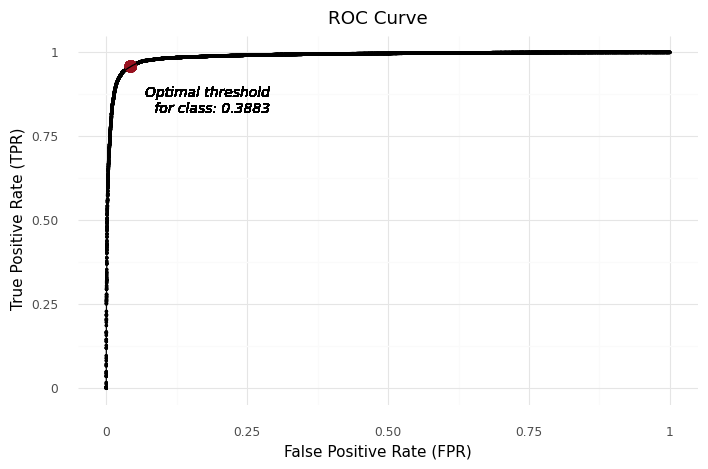

<ggplot: (8786226723581)>

In [51]:
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_fpr_tpr)+
    geom_point(aes(x = 'FPR',
                   y = 'TPR'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = fprOpt,
                   y = tprOpt),
               color = '#981220',
               size = 4)+
    geom_line(aes(x = 'FPR',
                  y = 'TPR'))+
    geom_text(aes(x = fprOpt,
                  y = tprOpt),
              label = 'Optimal threshold \n for class: {}'.format(thresholdOpt),
              nudge_x = 0.14,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'ROC Curve')+
    xlab('False Positive Rate (FPR)')+
    ylab('True Positive Rate (TPR)')+
    theme_minimal()
)

## Classifying USA Dataset

In [57]:
# load unseen dataset & assign to X

usa = pd.read_pickle("../data/usa_tweets_demo.pkl")
X = usa['text']

In [58]:
# vectorize X

X_vec_pred = vect.transform(X)

In [59]:
# predict probabilities for the new data

y_pred = model.predict_proba(X_vec_pred)

In [60]:
# classify data based on 0.5 threshold

believer_denier_preds = []

for i in y_pred:
    if i[1] < 0.3883:
        believer_denier_preds.append(0)
    else:
        believer_denier_preds.append(1)

In [61]:
# add classifications to the dataset

usa['believer_denier'] = believer_denier_preds
usa['believer_denier'].value_counts()

1    114667
0     36131
Name: believer_denier, dtype: int64

In [62]:
# add classifications to the dataset

usa['believer_denier'] = believer_denier_preds
usa['believer_denier'].value_counts()

1    114667
0     36131
Name: believer_denier, dtype: int64

In [63]:
usa[['text','believer_denier']]

,text,believer_denier
0,ll juice left carrot tonight fresh juice morni...,1
1,climate fact course warm year concern learn cl...,1
2,planet great winner world move ahead actonclim...,1
3,teen activist meet staff ve lose faith humanit...,1
4,rescue refugee land sea fleeing conflict need ...,1
...,...,...
150793,savage energy partner record break fiscal quar...,1
150794,hard tell snakeoil chemtrail globalwarmingisah...,0
150795,standard winter hurricane warn part florida yi...,1
150796,happy new yeaя fan globalwarmingisahoax hoax f...,1


In [64]:
# sanity check classifications

believers = usa.loc[usa['believer_denier'] == 1]
believers = believers.reset_index(drop=True)

deniers = usa.loc[usa['believer_denier'] == 0]
deniers = deniers.reset_index(drop=True)

In [65]:
believers['text'][5]

'suggest read thread climatechangeisreal ignore'

In [66]:
believers['text'][50]

'way realestate developer stay ahead climate change smartcitie climateaction'

In [67]:
deniers['text'][3]

'globalwarminghoax believer repent link video climatebarbie head south'

In [69]:
deniers['text'][100]

'president trump drop climate change list national security threat maga draintheswamp'

In [70]:
# save classified dataset

usa.to_pickle("../data/usa_classified_tweets.pkl")